In [1]:
import pandas as pd
import re
import os

<h4>Prepare the data</h4>

In [60]:

# Set the path to the data directory
data_directory = "data"

# Get the folder names in the data directory
folders = [folder_name for folder_name in os.listdir(data_directory)
           if os.path.isdir(os.path.join(data_directory, folder_name))]

# Create an empty list to store the data
data = []

# Iterate over the folders
for folder in folders:
    folder_path = os.path.join(data_directory, folder)

    # Iterate over the files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)

            # Read the email content from the file
            with open(file_path, 'r', encoding='latin-1') as file:
                content = file.read()

            # Handle the case when no suitable encoding is found
            if content is None:
                print(f"Error reading file: {file_path}")
                continue

            # Create a dictionary for the row
            row = {"content": str(content), "label": folder}

            # Append the row dictionary to the data list
            data.append(row)

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Set the output CSV file path
csv_file = "email_data.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file, index=False)


<h4>Clean up email content</h4>

In [67]:
df = pd.read_csv(csv_file)

df.head()

,content,label
0,"\nExcerpts from the Clipper announcement, with...",Entertainment
1,"\nIn article <strnlghtC5toC6.KIu@netcom.com>, ...",Entertainment
2,Sender: news@cujo.curtin.edu.au (News Manager)...,Entertainment
3,\n I've been thinking about how difficult it...,Entertainment
4,\nIn article merlin@lerami.lerctr.org (David H...,Entertainment


In [68]:
import tiktoken

max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

encoding = tiktoken.get_encoding('cl100k_base')

# omit rows are too long to embed
df['content'] = df['content'].astype(str)
df["token_count"] = df.content.apply(lambda x: len(encoding.encode(x)))
df = df[df.token_count <= max_tokens]

# for each group in df, select 500 samples randomly
df = df.groupby('label').apply(lambda x: x.sample(n=500, random_state=42)).reset_index(drop=True)
df.rename(columns={'label': 'completions'}, inplace=True)
df.drop(columns=['token_count'], inplace=True)

df.to_csv('dataset.csv', index=False)

In [69]:
df.head()

,content,completions
0,\nIn article <1993Apr20.182038.12009@ee.eng.oh...,Crime
1,\namolitor@nmsu.edu (Andrew Molitor) writes:\n...,Crime
2,\nIn article <WCS.93Apr17034914@rainier.ATT.CO...,Crime
3,\nneuhaus@vier.informatik.uni-kl.de (Stephan N...,Crime
4,Message-ID: <duck.735466043@nuustak>\nReferenc...,Crime


<h4>Calculate embeddings</h4>

`This can take 15-20 mins.`

In [70]:
import openai
from dotenv import load_dotenv
from openai.embeddings_utils import get_embedding

load_dotenv()

openai.api_key = os.getenv("OPENAI_API_KEY")

df["embedding"] = df.content.apply(lambda x: get_embedding(x, engine="text-embedding-ada-002"))

df.to_csv('dataset_with_embeddings.csv', index=False)

In [77]:
embeddings_df = pd.read_csv('dataset_with_embeddings.csv')

embeddings_df.drop(columns=['Unnamed: 0'], inplace=True)

embeddings_df.to_csv('dataset_with_embeddings_2k.csv', index=False)

In [78]:
embeddings_df = pd.read_csv('dataset_with_embeddings_2k.csv')
embeddings_df.head()

,content,completions,embedding
0,\nIn article <1993Apr20.182038.12009@ee.eng.oh...,Crime,"[-0.0053983950056135654, -0.00961512140929699,..."
1,\namolitor@nmsu.edu (Andrew Molitor) writes:\n...,Crime,"[-0.02907322719693184, -0.02031181938946247, 0..."
2,\nIn article <WCS.93Apr17034914@rainier.ATT.CO...,Crime,"[0.0044673229567706585, 0.002422421472147107, ..."
3,\nneuhaus@vier.informatik.uni-kl.de (Stephan N...,Crime,"[-0.014637134037911892, 0.0023185978643596172,..."
4,Message-ID: <duck.735466043@nuustak>\nReferenc...,Crime,"[-0.017296286299824715, 0.010672768577933311, ..."


<h4>Classification using embeddings</h4>

In [89]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('dataset_with_embeddings_2k.csv')
df = df[df['completions'].isin(['Politics', 'Science'])]
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    list(df.embedding.values), df.completions, test_size=0.2, random_state=42
)

# train random forest classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

    Politics       0.92      0.97      0.94        96
     Science       0.97      0.92      0.95       104

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.95       200



In [90]:
y_test.unique()

array(['Science', 'Politics'], dtype=object)

RandomForestClassifier() - Average precision score over all classes: 0.31


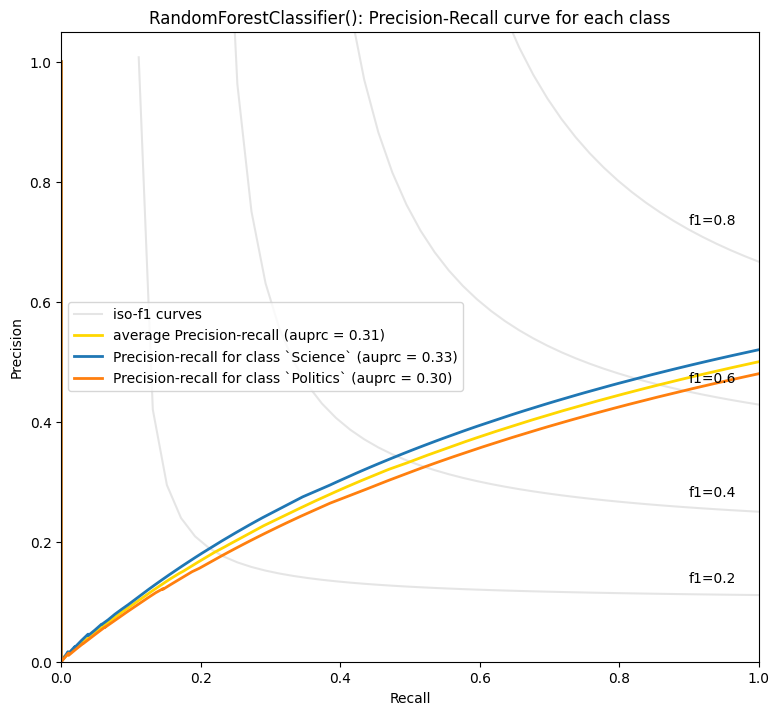

In [91]:
from openai.embeddings_utils import plot_multiclass_precision_recall

plot_multiclass_precision_recall(probas, y_test, ['Science', 'Politics'], clf)
